In [15]:

import math, random
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
from sklearn.preprocessing import KBinsDiscretizer
from copy import deepcopy
from collections import defaultdict
from scipy.stats import ks_2samp
# from ot import WassersteinDistance

FINGERPRINT_RADIUS = 2
FINGERPRINT_NBITS = 2048
TANIMOTO_CLUSTER_THRESHOLD = 0.8
TEST_FRACTION = 0.2
NUM_BINS = 8   
NUM_RESTARTS = 30
RANDOM_SEED = 42

NUMERIC_COLS = ['HLM','KSOL','LogD','MDR1-MDCKII','MLM']

# ============================
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def mol_from_smiles(smiles):
    try:
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return None
        Chem.SanitizeMol(m)
        return m
    except:
        return None

def fingerprint(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=FINGERPRINT_RADIUS, nBits=FINGERPRINT_NBITS)

def cluster_butina(fps, cutoff=TANIMOTO_CLUSTER_THRESHOLD):
    # fps: list of RDKit explicit bitvectors
    # returns list of clusters: each cluster is list of indices
    n = len(fps)
    # compute distance matrix in upper-triangular form as required by Butina
    dists = []
    for i in range(1, n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        # Butina expects distances, so use 1 - sim
        dists.extend([1.0 - s for s in sims])
    # Butina takes cutoff as distance threshold
    clusters = Butina.ClusterData(dists, n, 1.0 - cutoff, isDistData=True)
    # clusters is tuple of tuples (indices)
    return [list(c) for c in clusters]

def compute_cluster_stats(df, clusters, numeric_cols=NUMERIC_COLS, num_bins=NUM_BINS):
    # returns cluster_info: dict cluster_id -> { 'indices': [...], 'count': int,
    #   'medians': {col:median}, 'histograms': {col: hist normalized}, 'missing_frac': {col: frac} }
    cluster_info = {}
    # For histogram bin edges, use global bins computed on full data per column (ignoring NaN)
    bin_edges = {}
    for col in numeric_cols:
        colvals = df[col].dropna().values.reshape(-1,1)
        if len(colvals) < 2:
            # fallback
            minv, maxv = 0.0, 1.0
            edges = np.linspace(minv, maxv, num_bins+1)
        else:
            est = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
            est.fit(colvals)
            # KBinsDiscretizer doesn't directly give edges; use quantiles
            quantiles = np.linspace(0, 1, num_bins+1)
            edges = np.quantile(colvals.flatten(), quantiles)
        bin_edges[col] = edges

    for cid, inds in enumerate(clusters):
        sub = df.iloc[inds]
        info = {}
        info['indices'] = inds
        info['count'] = len(inds)
        info['medians'] = {}
        info['missing_frac'] = {}
        info['hists'] = {}
        for col in numeric_cols:
            coldata = sub[col].dropna().values
            info['missing_frac'][col] = 1.0 - (len(coldata) / len(sub)) if len(sub)>0 else 1.0
            if len(coldata)>0:
                info['medians'][col] = float(np.median(coldata))
                # histogram using the global bin edges
                edges = bin_edges[col]
                hist, _ = np.histogram(coldata, bins=edges)
                # normalize to proportion (sum = count_non_missing)
                if hist.sum() > 0:
                    hist = hist.astype(float) / hist.sum()
                info['hists'][col] = hist
            else:
                info['medians'][col] = np.nan
                info['hists'][col] = np.zeros(num_bins)
        cluster_info[cid] = info
    # also compute global histograms for target comparison
    global_hists = {}
    for col in numeric_cols:
        coldata = df[col].dropna().values
        if len(coldata)>0:
            edges = bin_edges[col]
            hist, _ = np.histogram(coldata, bins=edges)
            hist = hist.astype(float) / hist.sum()
            global_hists[col] = hist
        else:
            global_hists[col] = np.zeros(num_bins)
    return cluster_info, bin_edges, global_hists

def distribution_distance(selected_clusters, cluster_info, global_hists, cols=NUMERIC_COLS):
    # compute L1 distance between aggregated histograms of selected clusters and global_hists
    # selected_clusters: list of cluster ids
    agg = {col: np.zeros_like(global_hists[col]) for col in cols}
    total_nonmissing = {col: 0.0 for col in cols}
    for cid in selected_clusters:
        info = cluster_info[cid]
        for col in cols:
            # weight by number of non-missing points in cluster for that column
            # cluster's non-missing count approximated by count * (1 - missing_frac)
            nm = info['count'] * (1.0 - info['missing_frac'][col])
            total_nonmissing[col] += nm
            agg[col] += info['hists'][col] * nm
    dist = 0.0
    for col in cols:
        if total_nonmissing[col] > 0:
            agg[col] = agg[col] / total_nonmissing[col]
        else:
            agg[col] = np.zeros_like(agg[col])
        # L1 distance
        dist += np.sum(np.abs(agg[col] - global_hists[col]))
        # wasserstein distance
   
    return dist

def greedy_select_clusters(cluster_info, global_hists, total_n, target_test_n, cols=NUMERIC_COLS, restarts=20):
    cluster_ids = list(cluster_info.keys())
    best_selection = None
    best_score = float('inf')
    for r in range(restarts):
        # random order
        order = deepcopy(cluster_ids)
        random.shuffle(order)
        selected = []
        sel_count = 0
        current_score = distribution_distance(selected, cluster_info, global_hists, cols)
        # greedy add clusters that reduce score until reach target (or cannot improve)
        improved = True
        while improved and sel_count < target_test_n:
            improved = False
            best_local = None
            best_local_score = current_score
            for cid in order:
                if cid in selected:
                    continue
                new_count = sel_count + cluster_info[cid]['count']
                # skip if would overshoot target a lot > target + max_cluster_size (allow small overshoot)
                if new_count > target_test_n + max(info['count'] for info in cluster_info.values()):
                    continue
                candidate = selected + [cid]
                sc = distribution_distance(candidate, cluster_info, global_hists, cols)
                # prefer candidates that reduce distribution distance AND do not overshoot target
                if sc < best_local_score:
                    best_local_score = sc
                    best_local = cid
            if best_local is not None:
                selected.append(best_local)
                sel_count += cluster_info[best_local]['count']
                current_score = best_local_score
                improved = True
            else:
                break
        # if still below target_n, try to add smallest clusters (to reach target) even if score not improved much
        if sel_count < target_test_n:
            # sort remaining by count ascending and add until target reached
            remaining = [cid for cid in cluster_ids if cid not in selected]
            remaining.sort(key=lambda x: cluster_info[x]['count'])
            for cid in remaining:
                if sel_count >= target_test_n:
                    break
                selected.append(cid)
                sel_count += cluster_info[cid]['count']
            current_score = distribution_distance(selected, cluster_info, global_hists, cols)
        # record best
        # also penalize big deviation from target size
        size_penalty = abs(sel_count - target_test_n) / target_test_n
        total_score = current_score + 0.1 * size_penalty  # weight of size penalty can be tuned
        if total_score < best_score:
            best_score = total_score
            best_selection = (selected, sel_count, current_score)
    return best_selection, best_score


def structural_stratified_split(df, smiles_col='smiles', numeric_cols=NUMERIC_COLS,
                                test_fraction=TEST_FRACTION, tanimoto_thresh=TANIMOTO_CLUSTER_THRESHOLD,
                                num_bins=NUM_BINS, restarts=NUM_RESTARTS):
    # compute molecules and fingerprints
    mols = []
    valid_idx = []
    for i, s in enumerate(df[smiles_col].astype(str).tolist()):
        m = mol_from_smiles(s.split()[0]) if isinstance(s, str) else mol_from_smiles(s)
        # some of your SMILES may have " |a:... " suffix; split off by space if present
        if m is None:
            print(f"Warning: invalid SMILES at index {i}")
            continue
        mols.append(m)
        valid_idx.append(i)
    if len(mols) != len(df):
        print("Note: some rows had invalid SMILES and will be dropped for splitting.")
    fps = [fingerprint(m) for m in mols]
    clusters = cluster_butina(fps, cutoff=tanimoto_thresh)
    print(f"Formed {len(clusters)} structure clusters for {len(fps)} molecules.")
    # map cluster indices back to dataframe indices
    clusters_mapped = []
    for cl in clusters:
        mapped = [valid_idx[i] for i in cl]
        clusters_mapped.append(mapped)
    # prepare df subset for valid indices
    df_valid = df.copy().reset_index(drop=True)
    # but cluster indices refer to original df index positions; convert if needed
    # for simplicity, we will assume df indices are 0..n-1 as in your example
    cluster_info, bin_edges, global_hists = compute_cluster_stats(df_valid, clusters_mapped, numeric_cols, num_bins)
    total_n = len(df_valid)
    target_test_n = int(round(test_fraction * total_n))
    print(f"Total molecules (valid): {total_n}, desired test size: {target_test_n}")
    best_selection, best_score = greedy_select_clusters(cluster_info, global_hists, total_n, target_test_n, cols=numeric_cols, restarts=restarts)
    selected_clusters, sel_count, curr_dist = best_selection
    print(f"Selected {len(selected_clusters)} clusters for test, total molecules in test: {sel_count}, dist score: {curr_dist:.4f}")
    # build assignment Series
    assign = np.array(['Train'] * total_n)
    for cid in selected_clusters:
        for idx in cluster_info[cid]['indices']:
            assign[idx] = 'Valid'
    # return df with assignment column
    df_out = df_valid.copy()
    df_out['Set_split'] = assign
    return df_out, clusters_mapped, cluster_info, bin_edges, global_hists




In [16]:


df = pd.read_csv('dataset/raw/train_polaris.csv')
print(df.head())

df_out, clusters, cluster_info, bin_edges, global_hists = structural_stratified_split(df)
print(f"df processed: \n {df_out}")
print(f"the clusters are{clusters}")
print(f"the cluster info is {cluster_info}")
print(f"the bin edges are {bin_edges}")
print(f"the global hists are {global_hists}")
df_out.to_csv('dataset/processed/train_valid_polaris.csv', index=False)

                                              smiles  MLM  HLM   KSOL  LogD  \
0  COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...  NaN  NaN    NaN   0.3   
1  O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...  NaN  NaN  333.0   2.9   
2  O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...  NaN  NaN    NaN   0.4   
3  NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...  NaN  NaN  376.0   1.0   
4   CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|  NaN  NaN  375.0  -0.3   

   MDR1-MDCKII  
0          2.0  
1          0.2  
2          0.5  
3          8.5  
4          0.9  
Formed 315 structure clusters for 434 molecules.
Total molecules (valid): 434, desired test size: 87


[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerator
[12:16:02] DEPRECATION WARNING: please use MorganGenerat

Selected 52 clusters for test, total molecules in test: 87, dist score: 0.4642
df processed: 
                                                 smiles    MLM    HLM   KSOL  \
0    COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...    NaN    NaN    NaN   
1    O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...    NaN    NaN  333.0   
2    O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...    NaN    NaN    NaN   
3    NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...    NaN    NaN  376.0   
4     CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|    NaN    NaN  375.0   
..                                                 ...    ...    ...    ...   
429        CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|   63.0   25.5    NaN   
430               O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl  386.0  216.0    NaN   
431          NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1    NaN    NaN    NaN   
432        COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1    NaN    NaN    NaN   
433  CC1=NC=CN1C[C@H]1CCC2=C(C1=O)C1

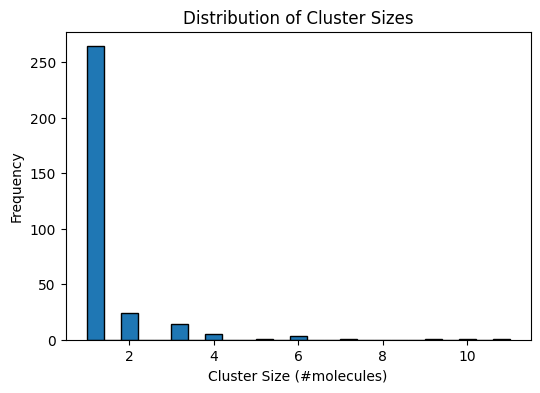

In [17]:
import matplotlib.pyplot as plt


cluster_sizes = [len(v) for v in clusters]
plt.figure(figsize=(6,4))
plt.hist(cluster_sizes, bins=25, edgecolor="k")
plt.xlabel("Cluster Size (#molecules)")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Sizes")
plt.show()


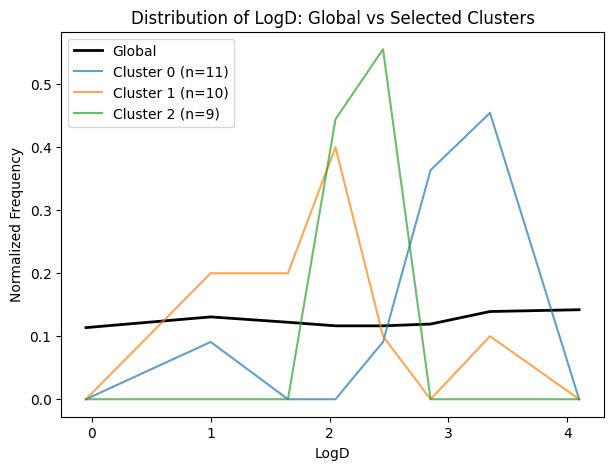

In [18]:
import numpy as np

def plot_cluster_vs_global(cluster_info, global_hists, bin_edges, col, cluster_ids=None):

    if cluster_ids is None:
     
        cluster_ids = sorted(cluster_info.keys(), key=lambda x: cluster_info[x]["count"], reverse=True)[:3]
    
    bins = bin_edges[col]
    centers = 0.5*(bins[:-1] + bins[1:]) 
    
    plt.figure(figsize=(7,5))
    
    # global
    plt.plot(centers, global_hists[col], label="Global", color="black", linewidth=2)
    
    # clusters
    for cid in cluster_ids:
        h = cluster_info[cid]["hists"][col]
        plt.plot(centers, h, label=f"Cluster {cid} (n={cluster_info[cid]['count']})", alpha=0.7)
    
    plt.xlabel(col)
    plt.ylabel("Normalized Frequency")
    plt.title(f"Distribution of {col}: Global vs Selected Clusters")
    plt.legend()
    plt.show()
plot_cluster_vs_global(cluster_info, global_hists, bin_edges, col="LogD")


/var/folders/7c/p9wzcv350d77mk56pvl5ycl00000gn/T/ipykernel_1760/1137204411.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=set_col)


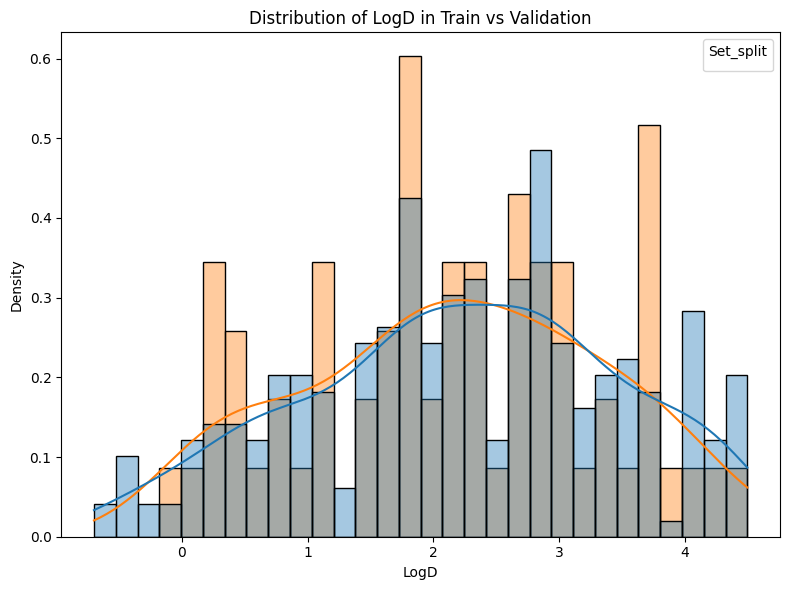

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_logD_distribution(df, col="LogD", set_col="Set"):
    plt.figure(figsize=(8,6))
    
    # histogram + kde
    sns.histplot(data=df, x=col, hue=set_col, bins=30, stat="density", common_norm=False, kde=True, alpha=0.4)

    plt.xlabel("LogD")
    plt.ylabel("Density")
    plt.title("Distribution of LogD in Train vs Validation")
    plt.legend(title=set_col)
    plt.tight_layout()
    plt.show()

plot_logD_distribution(df_out, col="LogD", set_col="Set_split")

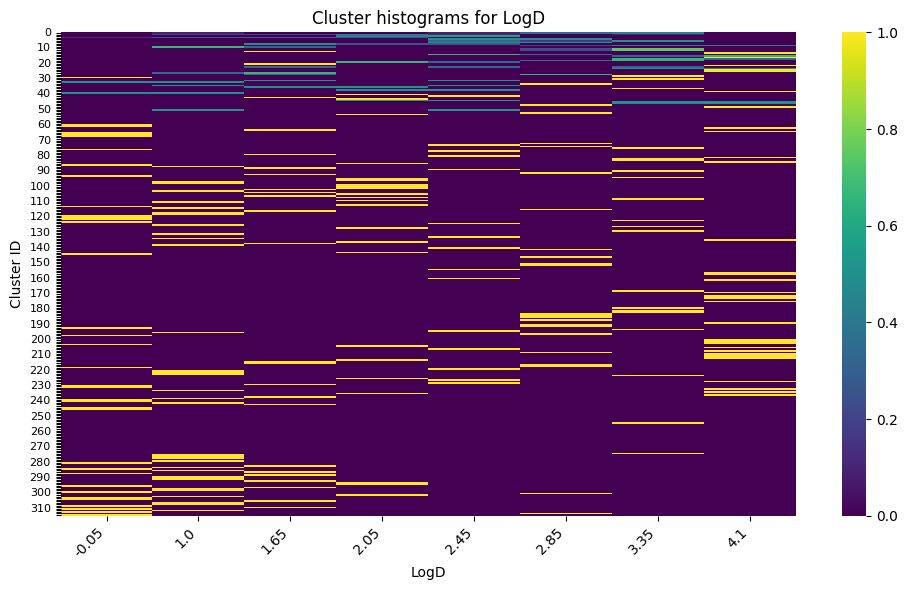

In [20]:
def plot_cluster_heatmap(cluster_info, col, bin_edges, max_labels=30):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    bins = bin_edges[col]
    centers = 0.5*(bins[:-1] + bins[1:])

    # build matrix
    cluster_ids = sorted(cluster_info.keys())
    data = [cluster_info[cid]["hists"][col] for cid in cluster_ids]
    data = np.array(data)

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data, cmap="viridis", xticklabels=np.round(centers,2), yticklabels=cluster_ids)

    # only show a subset of y labels if too many
    if len(cluster_ids) > max_labels:
        step = len(cluster_ids) // max_labels
        for idx, label in enumerate(ax.get_yticklabels()):
            if idx % step != 0:
                label.set_visible(False)

    plt.xlabel(col)
    plt.ylabel("Cluster ID")
    plt.title(f"Cluster histograms for {col}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()

plot_cluster_heatmap(cluster_info, col="LogD", bin_edges=bin_edges)


sim_train: [0.0945945945945946, 0.1111111111111111, 0.15, 0.12857142857142856, 0.13414634146341464, 0.14102564102564102, 0.1282051282051282, 0.10975609756097561, 0.14457831325301204, 0.12345679012345678, 0.13924050632911392, 0.12195121951219512, 0.1125, 0.09302325581395349, 0.1038961038961039, 0.09302325581395349, 0.09090909090909091, 0.07954545454545454, 0.10975609756097561, 0.07865168539325842, 0.11363636363636363, 0.10256410256410256, 0.1375, 0.10810810810810811, 0.09090909090909091, 0.13580246913580246, 0.12345679012345678, 0.12658227848101267, 0.13580246913580246, 0.12658227848101267, 0.14457831325301204, 0.08108108108108109, 0.10843373493975904, 0.08450704225352113, 0.0945945945945946, 0.0945945945945946, 0.08571428571428572, 0.1038961038961039, 0.12195121951219512, 0.136986301369863, 0.1095890410958904, 0.1038961038961039, 0.12658227848101267, 0.1111111111111111, 0.09876543209876543, 0.10810810810810811, 0.08860759493670886, 0.1388888888888889, 0.08860759493670886, 0.10389610389

[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerator
[12:18:54] DEPRECATION WARNING: please use MorganGenerat

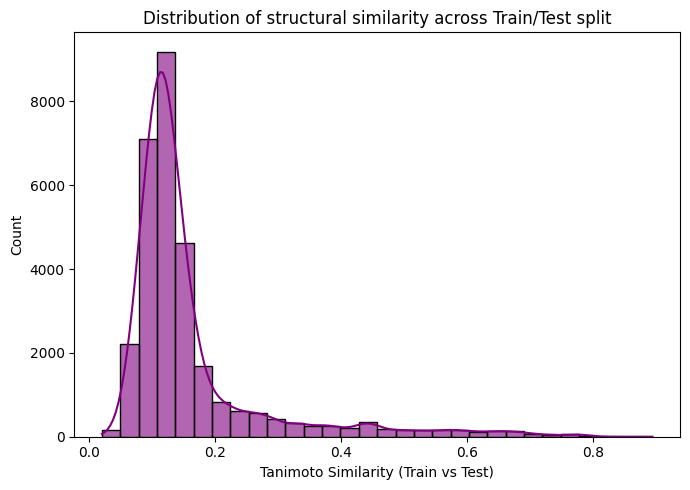

In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

def smiles_to_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
def compute_train_test_similarity(df, set_col="Set_split", smiles_col="smiles"):
    train_smiles = df[df[set_col]=="Train"][smiles_col].dropna().tolist()
    test_smiles  = df[df[set_col]=="Valid"][smiles_col].dropna().tolist()

    train_fps = [smiles_to_fp(s) for s in train_smiles if smiles_to_fp(s) is not None]
    test_fps  = [smiles_to_fp(s) for s in test_smiles if smiles_to_fp(s) is not None]

    sims = []
    for fp_train in train_fps:
        row = [DataStructs.TanimotoSimilarity(fp_train, fp_test) for fp_test in test_fps]
        sims.extend(row)
    for i in range(len(train_fps)):
        sim_train = DataStructs.BulkTanimotoSimilarity(train_fps[i], train_fps[:i])
    for i in range(len(test_fps)):
        sim_test = DataStructs.BulkTanimotoSimilarity(test_fps[i], test_fps[:i])
    return np.array(sims), sim_train, sim_test

import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_distribution(sims):
    plt.figure(figsize=(7,5))
    sns.histplot(sims, bins=30, kde=True, color="purple", alpha=0.6)
    plt.xlabel("Tanimoto Similarity (Train vs Test)")
    plt.ylabel("Count")
    plt.title("Distribution of structural similarity across Train/Test split")
    plt.tight_layout()
    plt.show()
sims, sim_train, sim_test = compute_train_test_similarity(df_out)
print(f"sim_train: {sim_train} len:{len(sim_train)}")
print(f"sim_test:{sim_test} len:{len(sim_test)}")
print(f"the mean inter-similarity between train and test is {np.mean(sims)}")
print(f"the mean intra-similarity of train set is {np.mean(sim_train)}")
print(f" the mean intra-similarity of test set is {np.mean(sim_test)}")
plot_similarity_distribution(sims)